# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
import random 
import copy
import pandas as pd
from scipy.stats import multivariate_normal
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [4]:
class my_GMM():
    
    def __init__(self, k , max_iter=20 , diag_cov = False):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        diag_cov : boolean 
            True when use diagonal covariance matrix , False if we use general form. 
        '''
        self.mu_ = None
        self.Sigma_ = None
        self.pi_=None
        self.cond_prob_ = None
        self.labels_ = None
        self.k_=k
        self.eps_ = 1e-3
        self.tab_likeli=[]
        self.max_iter_= max_iter
        self.diag_cov=diag_cov
    def compute_condition_prob_matrix(self,X, pi_,mu, Sigma):
        '''Compute the conditional probability matrix 
        shape: (n, K)
        '''
        n,p = X.shape
        cond_prob=np.zeros((n,self.k_)) 
        for i in range(n):
            all_densities,s=[],0
            for k in range(self.k_):
                density_k=multivariate_normal(mu[k],Sigma[k])
                dens=density_k.pdf(X[i])
                all_densities.append(pi_[k]*dens)
                s+=pi_[k]*dens

            for k in range(self.k_): 
                cond_prob[i,k]=all_densities[k]/s

        return cond_prob
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        def update_mean(X) :
            n,p=X.shape
            for j in range(self.k_) :
                S=np.zeros((p,))
                for i in range(n) :
                     S+=self.cond_prob_[i,j] * X[i]
                self.mu_[j] = (1/(self.pi_[j]*n)) * S
        def update_sigma(X) :
            n,p=X.shape
            for j in range(self.k_) :
                if self.diag_cov : 
                    S=np.zeros((p,))
                else : 
                    S=np.zeros((p,p))
                for i in range(n) :
                    if self.diag_cov : 
                        S+=self.cond_prob_[i,j] * np.square((X[i]-self.mu_[j]))
                    else : 
                        S+=self.cond_prob_[i,j] * (X[i]-self.mu_[j]) @ (X[i]-self.mu_[j]).T
                    
                self.Sigma_[j]=(1/(self.pi_[j]*n)) * S
                if self.diag_cov :
                    self.Sigma_[j] = np.diag(self.Sigma_[j])
                    
            
                    
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters
        
        # Update labels_
        
        ## initialization
        n,p = X.shape
        kmeans = KMeans(n_clusters=self.k_).fit(X)
        self.pi_=[list(kmeans.labels_).count(j)/n for j in range(self.k_) ]
        self.mu_=[(1/(self.pi_[j]*n)) * np.sum(X[np.where(kmeans.labels_ == j)[0]],axis=0) for j in range(self.k_)]
        
        #initialize sigma : 
        self.Sigma_=[]
        for j in range(self.k_) :
            if self.diag_cov : 
                S=np.zeros((p,))
            else : 
                S=np.zeros((p,p))
            for i in range(n) :
                if kmeans.labels_[i] == j :
                    if self.diag_cov : 
                        S+=np.square((X[i]-self.mu_[j]))
                    else :
                        S+=(X[i]-self.mu_[j]) @ (X[i]-self.mu_[j]).T
            self.Sigma_.append((1/(self.pi_[j]*n)) * S)
            if self.diag_cov :
                self.Sigma_[j] = np.diag(self.Sigma_[j])
        
        self.cond_prob_=self.compute_condition_prob_matrix(X, self.pi_, self.mu_, self.Sigma_)
        likeli_new = self.calculate_likelihood(X)
        
        likelihood_dif= np.inf
        n_iter=0
        while  (likelihood_dif> self.eps_) and (n_iter<self.max_iter_) :
            n_iter+=1
            likeli_old = likeli_new
            ## M Step 
            self.pi_=[(1/n)* np.sum(self.cond_prob_[:,j],axis=0) for j in range(self.k_) ]
            update_mean(X)
            update_sigma(X)
            
            ## E step 
            self.cond_prob_=self.compute_condition_prob_matrix(X, self.pi_, self.mu_, self.Sigma_)
            
            likeli_new=self.calculate_likelihood(X)
            likelihood_dif = np.abs(likeli_new-likeli_old)
                  
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob = self.compute_condition_prob_matrix(X, self.pi_,self.mu_, self.Sigma_)
        return np.argmax(cond_prob,axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        return self.compute_condition_prob_matrix(X, self.pi_,self.mu, self.Sigma)
    
    def calculate_likelihood(self,X):
        likeli=0
        n=len(X)
        for i in range(n):
            s=0
            for k in range(self.k_):
                density_k=multivariate_normal(self.mu_[k],self.Sigma_[k])
                dens=density_k.pdf(X[i])
                s+=self.pi_[k]* dens
            likeli+=np.log(s)
        return likeli
                

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

Text(0.5, 1.0, 'Clusters predicted by EM')

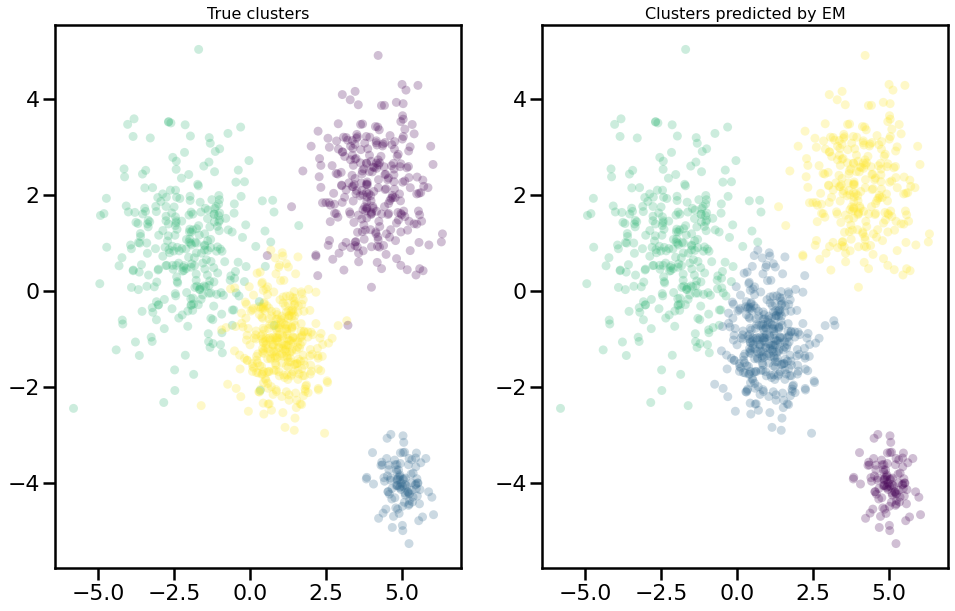

In [4]:
# TODO
def generate_random_sample(tab_pi,tab_mu,tab_sigma) :
    Z=np.random.multinomial(1, tab_pi, size=1)
    index = np.where(Z==1)[1][0]
    return index,np.random.multivariate_normal(tab_mu[index],tab_sigma[index])

    
tab_pi= [0.25 , 0.1 , 0.3 , 0.35 ]
n=1000
p=2

tab_mu=[np.array([4,2]),np.array([5,-4]),np.array([-2,1]),np.array([1,-1])] 
tab_sigma=[1 * np.eye(p),0.2 * np.eye(p),1.5 * np.eye(p),0.5 * np.eye(p)] 
X=np.zeros((n,p))

tab_labels = []
for i in range(n):
    k_,X[i]=generate_random_sample(tab_pi,tab_mu,tab_sigma)
    tab_labels.append(k_)
    
## Fit and plot data
gmm=my_GMM(k=4,diag_cov=True)
gmm.fit(X)
preds = gmm.predict(X)

fig, ax = plt.subplots(1,2,figsize=(16,10))
ax[0].scatter(X[:,0], X[:,1], c=tab_labels, **plot_kwds)
ax[0].set_title('True clusters', size=16)

ax[1].scatter(X[:,0], X[:,1], c=preds, **plot_kwds)
ax[1].set_title('Clusters predicted by EM', size=16)

We can observe that clusters are overall the same between ground truth and predictions. One main difference is that we have slightly higher variance for the true GMM model, i.e the clusters predicted by EM are more concentrated around their centroids. 

Remark :
Here we approximate the covariance matrixes of the gmm model by diagonal ones. So we calculate each time a vector of k elements instead of calculating $k^{2}$ elements.In fact, if we approximate the covariance matrix as usual ( $k^{2}$  elements ) , we obtain singular matrixes. To solve this I tried several methods , such as adding random matrixes so that our matrix becomes definite , in vain. The problem seems to disappear if we use diagonal matrixes.  
Still we created a parameter called *diag_cov* that is true if we use the approximation of diagonal matrix and false if we use the general form. 

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

In [20]:
# TODO
def AIC_BIC(X,k , diag_cov, bic = True, aic = True  ):
    gmm=my_GMM(k=k,diag_cov=diag_cov)
    gmm.fit(X)
    likeli = gmm.calculate_likelihood(X)
    if bic and aic :
        return likeli - 3*k - 1, likeli - (1/2)*(3*k-1)*len(X) , likeli - (1/2)*(3*k-1)*np.log(len(X))
    if bic  and aic == False:
        return likeli - (1/2)*(3*k-1)*len(X)
    if bic==False  and aic :
        return likeli - 3*k - 1
    return None 
    
    

- Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error 
    - Comparing the parameters

In [7]:
# TODO
from collections import defaultdict
from scipy import stats 
from itertools import combinations

def get_cluster (predictions):
    """
    Create dict that has keys as numbers of cluster and values the list of corresponding examples 
    """
    d = defaultdict(list)
    for i,cluster_label in enumerate(predictions) :
        d[cluster_label]+=[i]
    return dict(d) 
def test_closeness ( comb,val1,val2 , X,condition_prob_matrix,criterion,eps):
    """
    Test if clusters in comb are close enough, depending on the criterion.
    """

    if criterion =='correlation' : 
        x= condition_prob_matrix[:,comb[0]]
        y= condition_prob_matrix[:,comb[1]]
        pearson=stats.pearsonr (x,y)
        
        if np.abs(pearson[0]) > 1-eps :
            return True , 1-np.abs(pearson[0]) 
        
    elif criterion == 'distance':
        mu_1 = np.mean(X[val1],axis=0)
        mu_2 = np.mean(X[val2],axis=0)
        
        dist = np.linalg.norm(mu_1-mu_2)
        if dist < eps :
            return True , dist
    elif criterion =='parameter' :
        std_1 = np.std(X[val1],axis=0)
        std_2 = np.std (X[val2],axis=0)
        std_new = np.std (X[val1+val2] , axis = 0 )
        
        if std_new > std_1 + std_2 + eps :
            return True , std_new
   
    return False,None
        
def merge_two_clusters(d,X,keep_clusters,gmm_model) :
    """
    Merge two clusters.
    d : dict of the clusters. 
    keep_clusters : list of tuples. Each tuple contains the indexes of clusters to merge. 
    """
    elements_to_del=[]
    for clus1,clus2 in keep_clusters:
        new_cluster,cluster_del=min(clus1,clus2),max(clus1,clus2)
        n_1,n_2= len(d[clus1]),len(d[clus2])
        gmm_model.Sigma_[new_cluster]=(n_1*gmm_model.Sigma_[clus1] + n_2*gmm_model.Sigma_[clus2])/(n_1+n_2)
        gmm_model.mu_[new_cluster]=(n_1*gmm_model.mu_[clus1] + n_2*gmm_model.mu_[clus2])/(n_1+n_2)        
        gmm_model.pi_[new_cluster]=gmm_model.pi_[clus1]+gmm_model.pi_[clus2]
        
        gmm_model.k_-=1
        elements_to_del.append(cluster_del)
    
    gmm_model.Sigma_ =  [gmm_model.Sigma_[e] for e in range(len(gmm_model.Sigma_)) if e not in elements_to_del]
    gmm_model.mu_ =  [gmm_model.mu_[e] for e in range(len(gmm_model.mu_)) if e not in elements_to_del]
    gmm_model.pi_ =  [gmm_model.pi_[e] for e in range(len(gmm_model.pi_)) if e not in elements_to_del]
        
    gmm_model.cond_prob_=gmm_model.compute_condition_prob_matrix(X, gmm_model.pi_, gmm_model.mu_, gmm_model.Sigma_)
    
    return gmm_model.predict(X)

        
def merge_clusters (preds , X, gmm_model, criterion, eps) :
    """
    Function that merges clusters obtained by EM algorithm on gmm models.
    
    Params
    preds : a vector containing labels of the n Xi vectors
    X : (n,p) matrix of data. 
    gmm_model : the class of gmm model that we defined above.
    criterion : " correlation ", "distance" or "parameter." 
    eps : the threshold value , depends highly on the criterion.
    """
    merging=True
    while merging :
        to_merge=dict()
        ## Create dict that has keys as numbers of cluster and values the list of corresponding examples 
        dict_clusters = get_cluster (preds)
        ## all combinations of clusters 
        all_combs = list(combinations(list(dict_clusters.keys()), 2)) 
        merging=False
        for comb in all_combs :
            values_1,values_2 = dict_clusters[comb[0]],dict_clusters[comb[1]]
            test,dist=test_closeness(comb,values_1,values_2,X,gmm_model.cond_prob_,criterion,eps)
            if test==True :
                merging=True
                to_merge[comb] = dist 
        
        
        # sort dict by min distance
        to_merge={k: v for k, v in sorted(to_merge.items(), key=lambda item: item[1])}
        used_clusters=[]
        keep_clusters=[]
        for comb_clusters in to_merge.keys():
            clus1,clus2=comb_clusters
            if clus1 not in used_clusters  and clus2 not in used_clusters:
                used_clusters+=[clus1,clus2]
                keep_clusters+=[comb_clusters]
           
        preds = merge_two_clusters(dict_clusters,X,keep_clusters,gmm_model)
    
        
    
    

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

In [40]:
# TODO
import time 
data = pd.read_csv('Data/data_MM_1.csv' , header=None)
data.rename(columns={0:'dim_1',1:'dim_2',2:'dim_3'},inplace=True)
X_train=data.values
all_k = range(1,5)
tab_aic=[]
tab_bic=[]
tab_likeli=[]
t0=time.time()
for k in all_k :
    aic,bic,_ = AIC_BIC(X_train,k, diag_cov=True)
    tab_aic.append(aic)
    tab_bic.append(bic)
t1=time.time()
print('Execution time is {} s'.format(t1-t0))

Execution time is 60.13597083091736 s


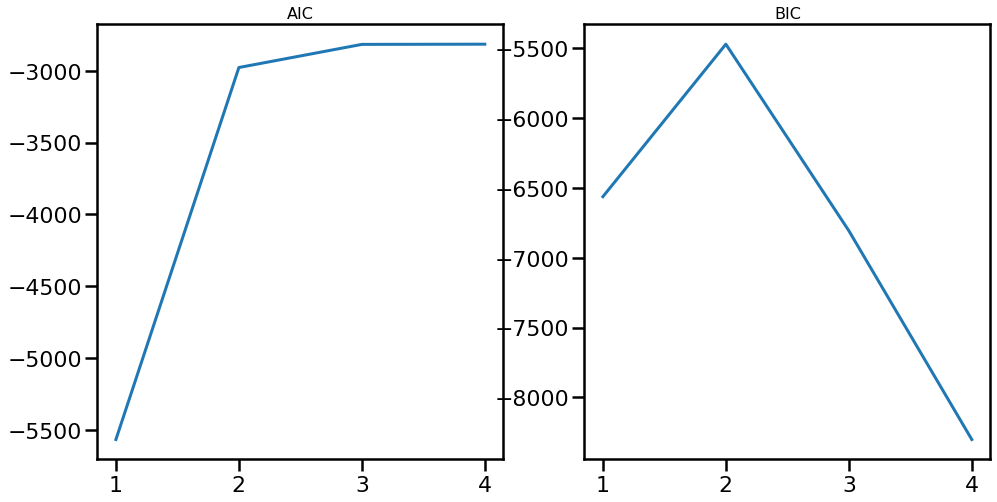

In [41]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(all_k, tab_aic)
ax[0].set_title('AIC', size=16)

ax[1].plot(all_k, tab_bic)
ax[1].set_title('BIC', size=16)

plt.show()

Text(0.5, 0.92, 'True clusters')

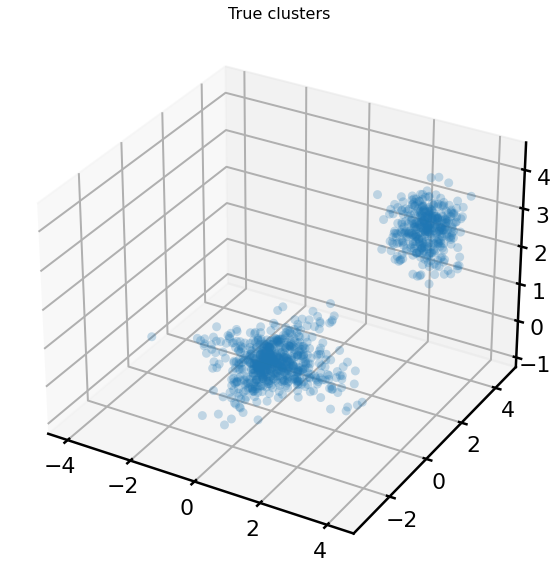

In [87]:
## Plot data to check values

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2] , **plot_kwds)
ax.set_title('True clusters', size=16)

We can observe that our data is  concentrated around two clusters. So The BIC metric gave us better approximation of the model order. Now, we will try model reduction method and confront the results with the ones obtained by AIC-BIC.

### Model reduction 

In [8]:
data = pd.read_csv('Data/data_MM_1.csv' , header=None)
data.rename(columns={0:'dim_1',1:'dim_2',2:'dim_3'},inplace=True)
X_train=data.values


## test with correlation 
tab_eps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tab_corr=[]
for eps in tab_eps : 
    ## We begin by k=5 and then reduce
    k=5 
    gmm=my_GMM(k=k,diag_cov=True)
    gmm.fit(X_train)
    preds = gmm.predict(X_train)
    merge_clusters (preds , X_train, gmm_model=gmm, criterion='correlation', eps=eps) 
    tab_corr.append(gmm.k_)
    
## test with distance 
tab_eps = [0.5,1,1.5,2,2.5,3]
tab_dis = []
for eps in tab_eps : 
    k=5 
    gmm=my_GMM(k=k,diag_cov=True)
    gmm.fit(X_train)
    preds = gmm.predict(X_train)
    merge_clusters (preds , X_train, gmm_model=gmm, criterion='distance', eps=eps) 
    tab_dis.append(gmm.k_)

Let's illustrate our results with a table. 


In [18]:
from prettytable import PrettyTable
table_cor = PrettyTable()

tab_eps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
table_cor.add_column("epsilon value ",tab_eps)
table_cor.add_column("k_min",tab_corr)
print('If criterion is correlation  \n',table_cor)

table_dis = PrettyTable()

tab_eps = [0.5,1,1.5,2,2.5,3]
table_dis.add_column("epsilon value ",tab_eps)
table_dis.add_column("k_min",tab_dis)
print('If criterion is distance  \n',table_dis)


If criterion is correlation  
 +----------------+-------+
| epsilon value  | k_min |
+----------------+-------+
|      0.2       |   5   |
|      0.3       |   5   |
|      0.4       |   4   |
|      0.5       |   1   |
|      0.6       |   1   |
|      0.7       |   1   |
|      0.8       |   1   |
|      0.9       |   1   |
+----------------+-------+
If criterion is distance  
 +----------------+-------+
| epsilon value  | k_min |
+----------------+-------+
|      0.5       |   5   |
|       1        |   4   |
|      1.5       |   3   |
|       2        |   2   |
|      2.5       |   2   |
|       3        |   2   |
+----------------+-------+


Let's finish with the execution time . 

In [42]:
k=5 
t0_merge=time.time()
gmm=my_GMM(k=k,diag_cov=True)
gmm.fit(X_train)
preds = gmm.predict(X_train)
merge_clusters (preds , X_train, gmm_model=gmm, criterion='distance', eps=2)
t1_merge=time.time()
print('Execution time for model reduction is {} s'.format(t1_merge-t0_merge))

Execution time for model reduction is 43.08991265296936 s


So the criterion distance gave us the right number of clusters for $\epsilon = 2$. It's clear that if we didn't have a plot of our data, or if it was more complex in its representation (the clusters are not separable for instance) , we would have a hard time deducing the true value of our model order. So the main issue with this model reduction method is the finetuning of parameter $\epsilon$ which depends on data values and the criterion. ( nevertheless for the example above with distance criterion , we can stop when we reach a "plateau" , i.e when espilon =2 and choose therefore $k_{min}$=2 ) 

Therefore, eventhough the model reduction was a litte bit faster, AIC-BIC metrics are more convenient because they don't need a finetuning of hyperparameters.

## Application

You are going to work with the following data:

shape: (1797, 64)


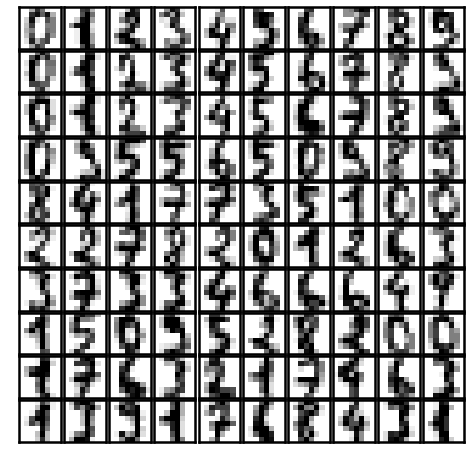

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [23]:
# TODO
from sklearn.decomposition import PCA

X_train = digits.data

pca = PCA(n_components=15)
X_reduced = pca.fit_transform(X_train)

tab_aic=[]
tab_bic=[]
tab_bic_log=[]
all_k = range(1,18)
for k in all_k :
    aic,bic,bic_log = AIC_BIC(X_reduced,k , diag_cov=True )
    tab_aic.append(aic)
    tab_bic.append(bic)
    tab_bic_log.append(bic_log) 

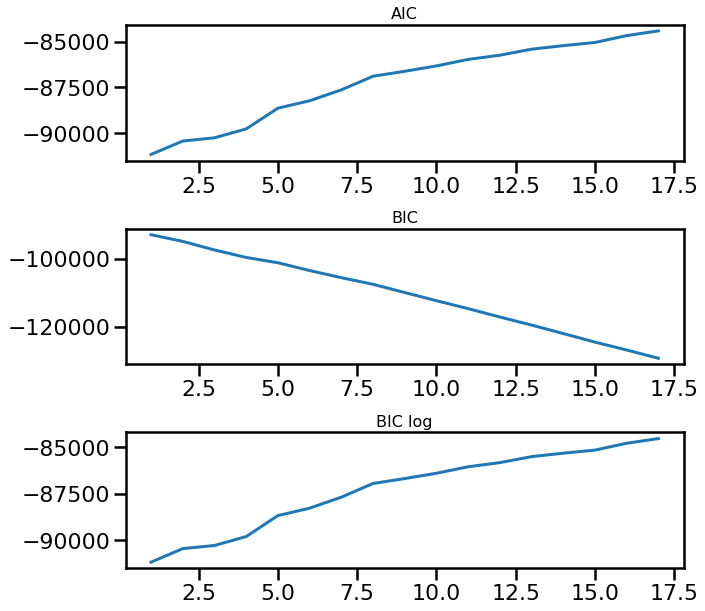

In [31]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(all_k, tab_aic)
ax[0].set_title('AIC', size=16)
ax[1].plot(all_k, tab_bic)
ax[1].set_title('BIC', size=16)

ax[2].plot(all_k, tab_bic_log)
ax[2].set_title('BIC log', size=16)

plt.show()

We observe that the BIC with log on the number of samples and and AIC gave close values , because the likelihood term is preponderant compared to the regularization term. Therefore , we can see that the models are not well regularized and the convenient value of model order is bigger than 10 , which is the number of classes. So BIC might be a good alternative , but here we have the inverse problem and BIC is always decreasing.

So a good alternative may be to regularize the term in $M_{j} n$ by a parameter $\alpha$. But here too we will have the problem of model reduction that is to finetune $\alpha $ , since we don't have any information on the "best" value , especially when we have high dimensional data and we can't plot the distribution to figure out a possible clustering . 

In [34]:
best_k=10
gmm=my_GMM(k=best_k , max_iter= 75, diag_cov =True)
gmm.fit(X_reduced)
preds = gmm.predict(X_reduced)


    

cluster 1 



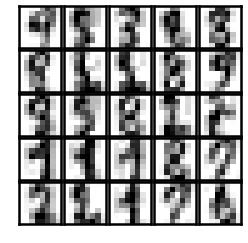

cluster 2 



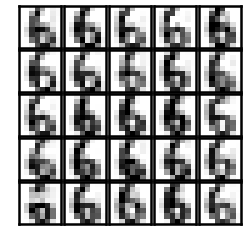

cluster 3 



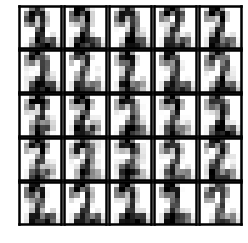

cluster 4 



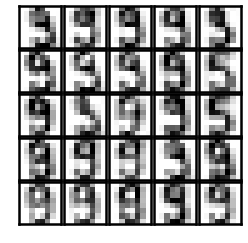

cluster 5 



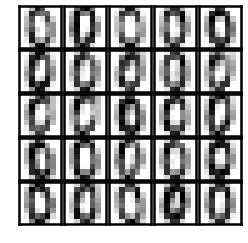

cluster 6 



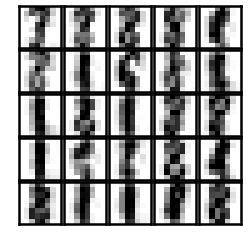

cluster 7 



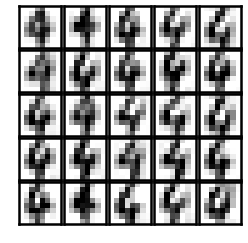

cluster 8 



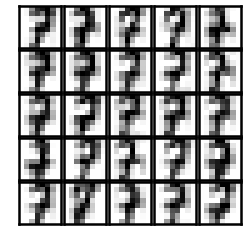

cluster 9 



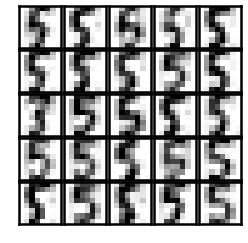

cluster 10 



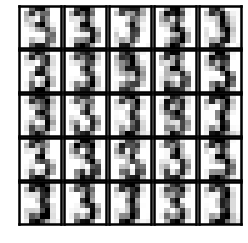

In [38]:
from random import sample

n_samples = 5
for k in range(best_k) : 
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(4,4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    args = np.where(preds == k )[0]
    sample_examples = sample(list(args),n_samples**2)
    X_reconstructed = pca.inverse_transform(X_reduced[sample_examples])
    for i, axi in enumerate(ax.flat):
        
        im = axi.imshow(X_reconstructed[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    print ('cluster {} \n'.format(k+1))
    plt.show()

If we choose a model order of 10, we can see that many clusters are homogeneous and represent the same numbers ( cluster 2, 3 , 5, 7 ,8 , 9 ,10 ). But others represent numbers with close shapes ( cluster 4 , which considers the representation of numbers of 9 and 5 as close) or even numbers that don't share commun class or shape. This is maybe due to the dimensionality reduction from 64 to 15, which discarded some important features in the original mnist data.

In general , the gmm model determined by EM algorithm succeed in assigning the mnist examples to clusters based on their class , with few exceptions. So a gmm with enough parameters can be good enough to model reduced representations of MNIST. But for high dimensional images such as CIFAR (3072 pixels) , we can conjecture that reducing the data may result in a bad reconstruction. So GMM + EM model won't be as expressive as for MNIST.